In [ ]:
%load_ext autoreload
%autoreload 2

In [32]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import windrose as wr

In [2]:
import sys
# local
sys.path.append('/Users/rthedin/eagle/a2e-mmc')
sys.path.append('/Users/temp/')
# Eagle
sys.path.append('/home/rthedin/a2e-mmc')
from mmctools.plotting import plot_profile

output_dir = 'data'
fig_dir = 'fig'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

# WIND Toolkit analysis: data analysis and post-processing
Regis Thedin (regis.thedin@nrel.gov)

This notebook uses processed data from `1-process_raw_data.ipynb`, `2-calculate_QOIs.ipynb`, and `3-characterize_conitions.ipynb`.


In [ ]:
zhub = 80    # hub height of TOTW is 80m
g=9.81
Cp = 1004

## 1. Load data

In [3]:
tsdata = 'WTK_ts.calc.csv'    # time-series data
columndata = 'WTK.calc.csv'   # time-height data

dfts = pd.read_csv(os.path.join(output_dir,tsdata),parse_dates=['datetime'],index_col=0)

dfcd_date = pd.read_csv(os.path.join(output_dir,columndata),parse_dates=['datetime'])
dfcd = dfcd_date.set_index(['datetime','height'])

In [4]:
height = dfcd.index.get_level_values('height')
fulldate = dfcd.index.get_level_values('datetime')

month = fulldate.month
timeOfDay = fulldate.hour

In [142]:
seasonaldata = {
    'spring': dfcd.loc[(month >= 3) & (month <= 5),:],
    'summer': dfcd.loc[(month >= 6) & (month <= 8),:],
    'fall':   dfcd.loc[(month >= 9) & (month <= 11),:],
    'winter': dfcd.loc[(month == 12) | (month <= 2),:],
}

monthlydata = {
    'jan': dfcd.loc[(month == 1)],
    'feb': dfcd.loc[(month == 2)],
    'mar': dfcd.loc[(month == 3)],
    'apr': dfcd.loc[(month == 4)],
    'may': dfcd.loc[(month == 5)],
    'jun': dfcd.loc[(month == 6)],
    'jul': dfcd.loc[(month == 7)],
    'aug': dfcd.loc[(month == 8)],
    'sep': dfcd.loc[(month == 9)],
    'oct': dfcd.loc[(month == 10)],
    'nov': dfcd.loc[(month == 11)],
    'dec': dfcd.loc[(month == 12)],
}

hourlydata = {
    '0'  : dfcd.loc[ (timeOfDay >= 0) & (timeOfDay< 1),  :],
    '1'  : dfcd.loc[ (timeOfDay >= 1) & (timeOfDay< 2),  :],
    '2'  : dfcd.loc[ (timeOfDay >= 2) & (timeOfDay< 3),  :],
    '3'  : dfcd.loc[ (timeOfDay >= 3) & (timeOfDay< 4),  :],
    '4'  : dfcd.loc[ (timeOfDay >= 4) & (timeOfDay< 5),  :],
    '5'  : dfcd.loc[ (timeOfDay >= 5) & (timeOfDay< 6),  :],
    '6'  : dfcd.loc[ (timeOfDay >= 6) & (timeOfDay< 7),  :],
    '7'  : dfcd.loc[ (timeOfDay >= 7) & (timeOfDay< 8),  :],
    '8'  : dfcd.loc[ (timeOfDay >= 8) & (timeOfDay< 9),  :],
    '9'  : dfcd.loc[ (timeOfDay >= 9) & (timeOfDay< 10), :],
    '10' : dfcd.loc[ (timeOfDay >= 10) & (timeOfDay<11), :],
    '11' : dfcd.loc[ (timeOfDay >= 11) & (timeOfDay<12), :],
    '12' : dfcd.loc[ (timeOfDay >= 12) & (timeOfDay<13), :],
    '13' : dfcd.loc[ (timeOfDay >= 13) & (timeOfDay<14), :],
    '14' : dfcd.loc[ (timeOfDay >= 14) & (timeOfDay<15), :],
    '15' : dfcd.loc[ (timeOfDay >= 15) & (timeOfDay<16), :],
    '16' : dfcd.loc[ (timeOfDay >= 16) & (timeOfDay<17), :],
    '17' : dfcd.loc[ (timeOfDay >= 17) & (timeOfDay<18), :],
    '18' : dfcd.loc[ (timeOfDay >= 18) & (timeOfDay<19), :],
    '19' : dfcd.loc[ (timeOfDay >= 19) & (timeOfDay<20), :],
    '20' : dfcd.loc[ (timeOfDay >= 20) & (timeOfDay<21), :],
    '21' : dfcd.loc[ (timeOfDay >= 21) & (timeOfDay<22), :],
    '22' : dfcd.loc[ (timeOfDay >= 22) & (timeOfDay<23), :],
    '23' : dfcd.loc[ (timeOfDay >= 23),  :],
}

## 2. Classify stability
From `3-characterize_conditions.ipynb`. Classification based on $L^{-1}$.

In [132]:
Lranges = np.array([-1,-50, -200, -500, 500, 200, 50, 1])
zL_ranges = 2.0 / Lranges
zL_range_names = ['VU','U','NU','N','NS','S','VS']

inrange = (dfts['z/L'] >= zL_ranges[0]) & (dfts['z/L'] <= zL_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

0 outliers out of 26304 (0%)


In [131]:
dfts['stability_zL'] = pd.cut(dfts['z/L'], bins=zL_ranges, labels=zL_range_names)
zL_ranges

array([-2.   , -0.04 , -0.01 , -0.004,  0.004,  0.01 ,  0.04 ,  2.   ])

## 3. Stability by the hour
Following plots from `3-characterize_conditions.ipynb`, looking at every 1-hour intervals.

In [140]:
zref=2 # for plotting

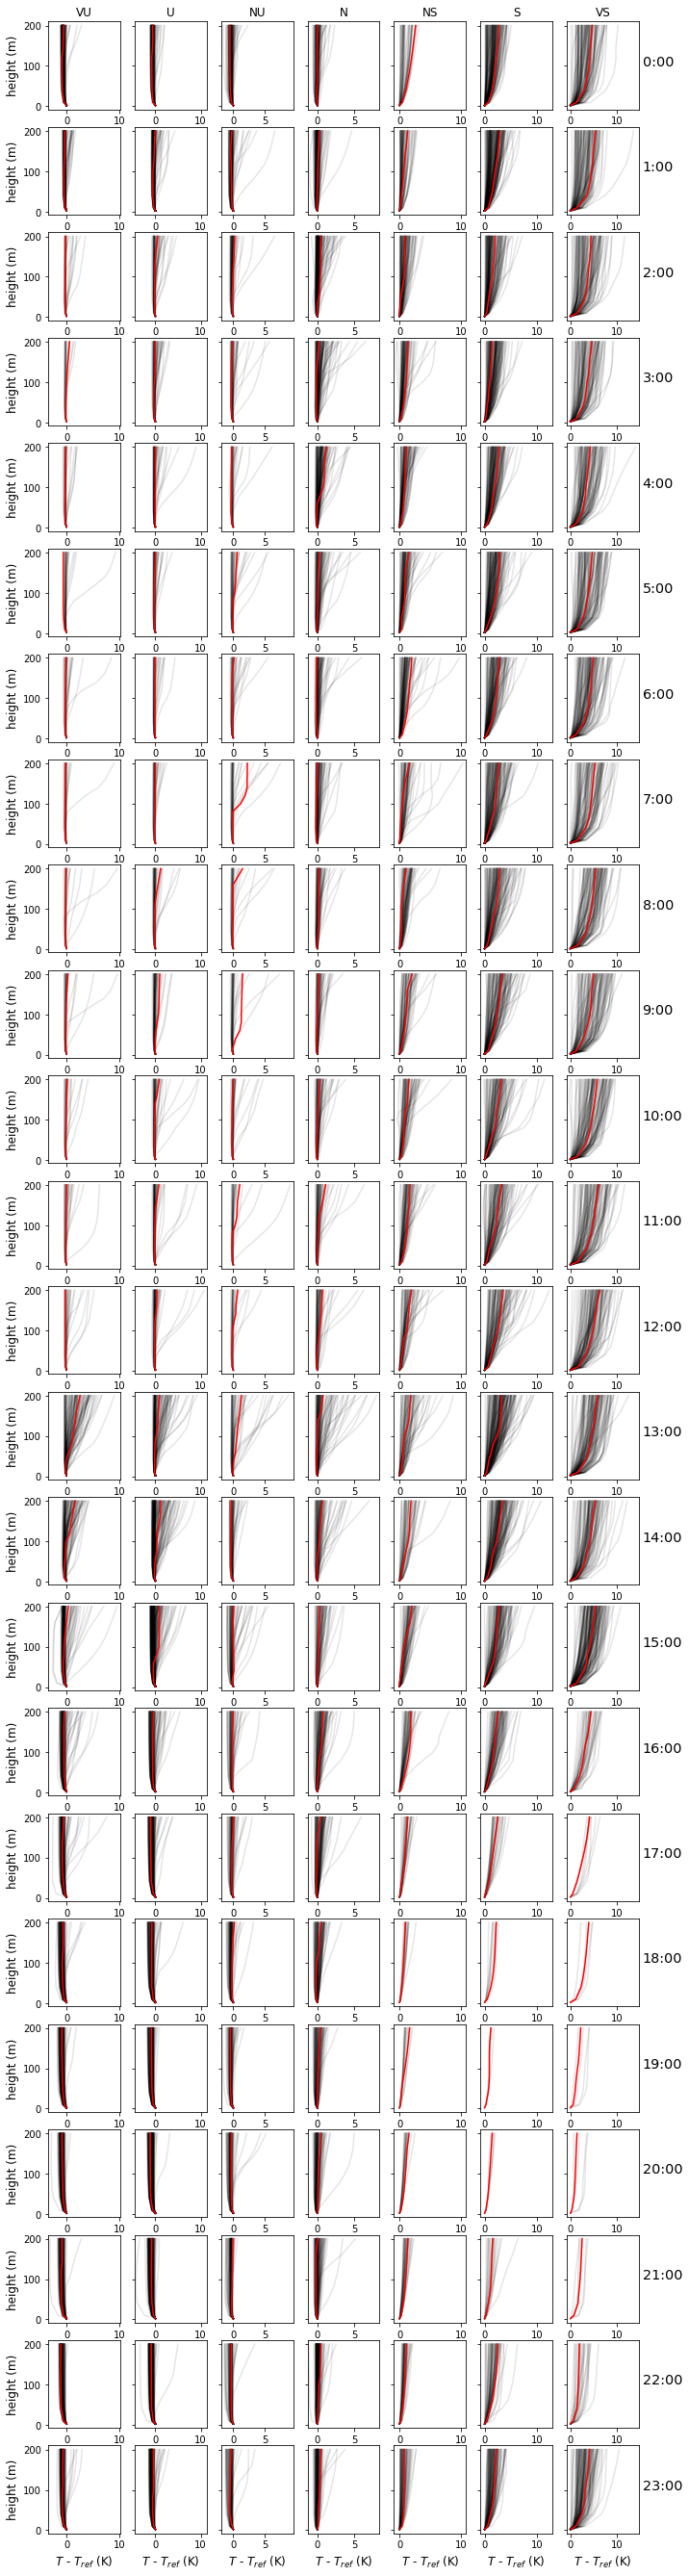

In [141]:
# Potential temperature plots
fig,ax = plt.subplots(nrows=24,ncols=7,sharey=True,figsize=(11,46))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(hour,data) in enumerate(hourlydata.items()):
    dates=data.index.levels[0]
    for icol,stab in enumerate(zL_range_names):
        temp = data.unstack().loc[dfts['stability_zL']==stab,:]
        median = temp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(temp)
        if N>100:
            temp = temp['thetav'].iloc[slice(0,N,int(N/Nplot))]
        else:
            temp = temp['thetav']
        for datetime,profile in temp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, f"{hour}:00", fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)
    
# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)
        
# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ (K)',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])

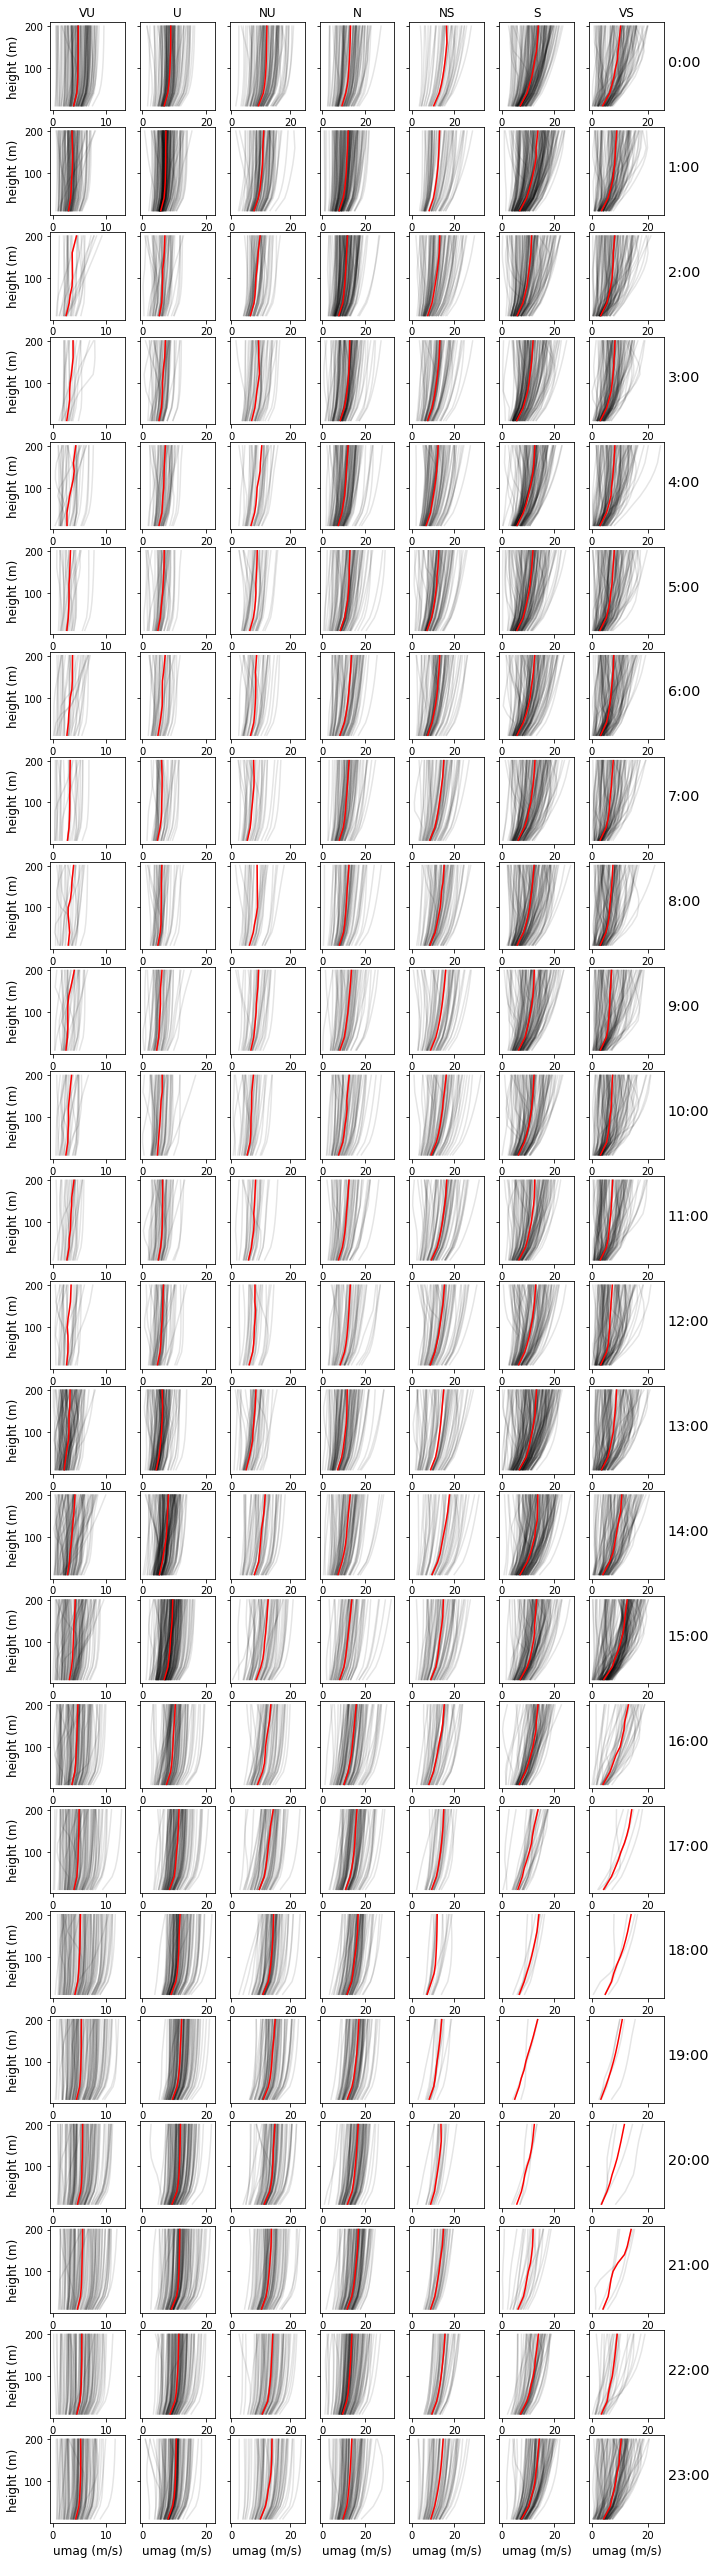

In [144]:
# Wind speed plots
fig,ax = plt.subplots(nrows=24,ncols=7,sharey=True,figsize=(11,46))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(hour,data) in enumerate(hourlydata.items()):
    dates=data.index.levels[0]
    for icol,stab in enumerate(zL_range_names):
        temp = data.unstack().loc[dfts['stability_zL']==stab,:]
        median = temp['windspeed'].median(axis=0)
        N = len(temp)
        if N>100:
            temp = temp['windspeed'].iloc[slice(0,N,int(N/Nplot))]
        else:
            temp = temp['windspeed']
        for datetime,profile in temp.iterrows():
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, f"{hour}:00", fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)
    
# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)
        
# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('umag (m/s)',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])

## 4. Wind speed by season

In [7]:
# Auxiliary plotting variables
hours_unique = pd.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
heights_unique = pd.array([2,10,40,60,80,100,120,140,160,200])

# Arrays for setting the ticks
hours_ticks =  np.linspace(0,23,24)
heights_ticks = np.array([10,40,60,80,100,120,140,160,200])

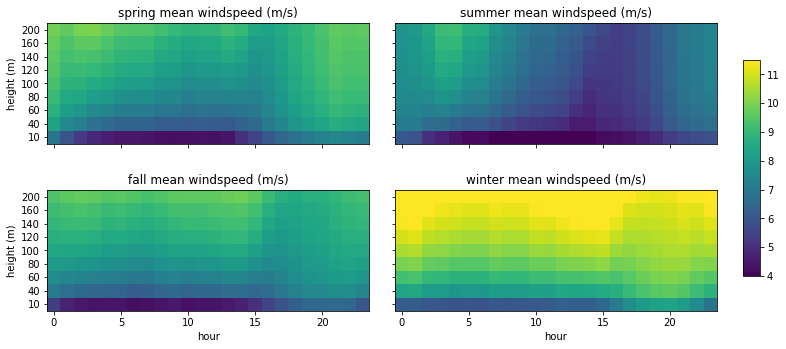

In [8]:
# Wind speed over the seasons, at every height for every hour
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.subplots_adjust(hspace=0.05, wspace=0.08)
ax=ax1.flatten()

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']
    ws = np.zeros(shape=(len(heights_unique),len(hours_unique)))
    for (i,z) in enumerate(heights_unique):
        for (j,h) in enumerate(hours_unique):
            d = data.reset_index().loc[(hour==h) & (height==z)]
            ws[i,j] = d['windspeed'].mean()
            
    # skipping first row bc it's empty (height=2)        
    p = ax[irow].imshow(ws[1:,:], origin='lower',vmin=4, vmax=11.5)
    ax[irow].set_title(f"{season} mean windspeed (m/s)")
    
# set labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5])
fig.colorbar(p, cax = cb_ax) 
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,8,9))
    axi.set_yticklabels(heights_ticks)
    

### - Focusing on the heights spanning the rotors

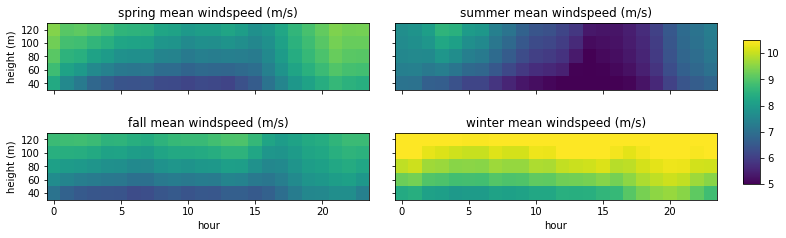

In [9]:
# Wind speed over the seasons, near-turbine heights, for every hour
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,4))
fig.subplots_adjust(hspace=0.02, wspace=0.08)
ax=ax1.flatten()

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']
    ws = np.zeros(shape=(len(heights_unique),len(hours_unique)))
    for (i,z) in enumerate(heights_unique):
        for (j,h) in enumerate(hours_unique):
            d = data.reset_index().loc[(hour==h) & (height==z)]
            ws[i,j] = d['windspeed'].mean()
            
    # skipping first row bc it's empty (height=2)        
    p = ax[irow].imshow(ws[2:7,:], origin='lower',vmin=5, vmax=10.5)
    ax[irow].set_title(f"{season} mean windspeed (m/s)")
    
# set labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5])
fig.colorbar(p, cax = cb_ax) 
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,4,5))
    axi.set_yticklabels(np.array([40,60,80,100,120]))
    

## 5. Daytime and nighttime wind roses
`windrose` convention for wind direction: northerly winds (from N to S) is 0 degrees, increase clockwise


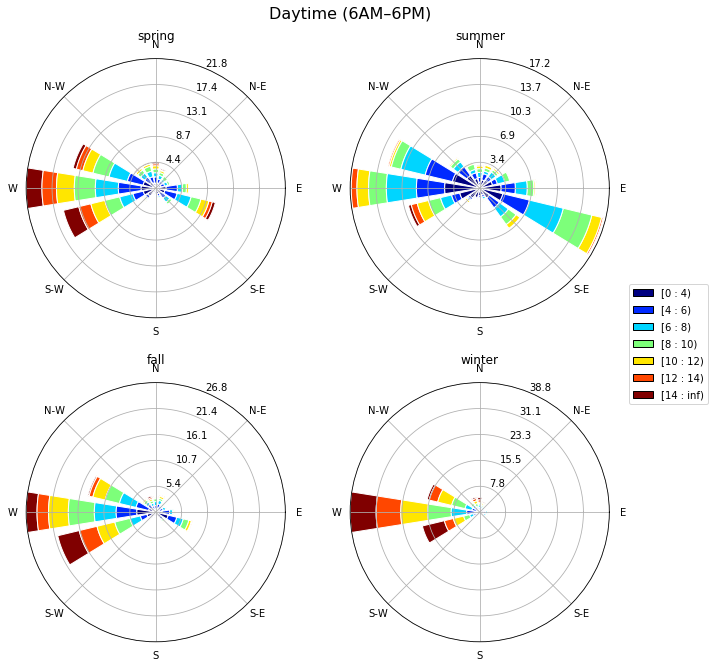

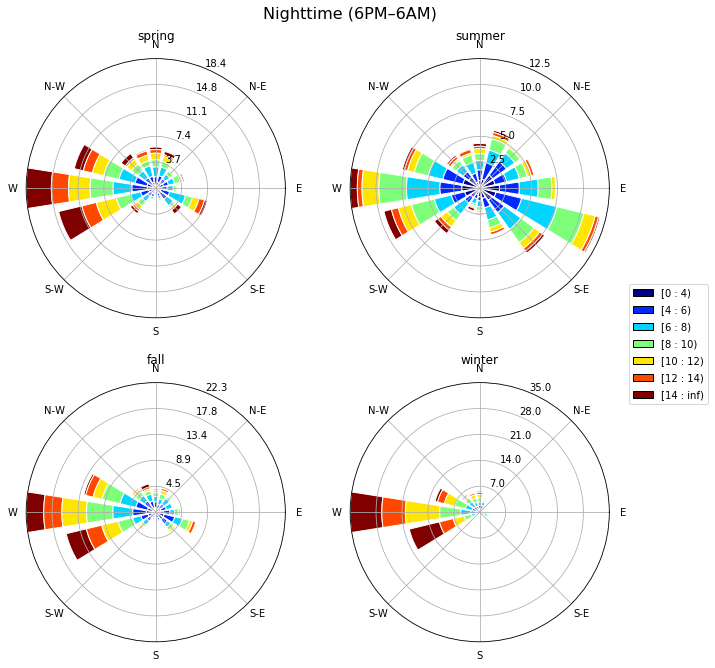

In [181]:
# Daytime
fig = plt.figure(figsize=(9,9))
rec = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
fig.suptitle('Daytime (6AM–6PM)', fontsize=16)

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']

    d = data.reset_index().loc[((hour>=6) & (hour<18)) & (height==zhub)]
    ws = d['windspeed'].values
    wd = d['winddirection'].values
    wa = wr.WindroseAxes(fig, rec[irow])
    fig.add_axes(wa)
    wa.bar(wd, ws, normed=True, bins=([0,4,6,8,10,12,14]), opening=0.8, edgecolor='white')
    wa.set_title(f"{season}")

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(1.4,0.9))
plt.show()  

print("\n\n")

# Nighttime
fig = plt.figure(figsize=(9,9))
fig.suptitle('Nighttime (6PM–6AM)', fontsize=16)

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']

    d = data.reset_index().loc[((hour>=18) | (hour<6)) & (height==zhub)]
    ws = d['windspeed'].values
    wd = d['winddirection'].values
    wa=wr.WindroseAxes(fig, rec[irow])
    fig.add_axes(wa)
    wa.bar(wd, ws, normed=True, bins=([0,4,6,8,10,12,14]), opening=0.8, edgecolor='white')
    wa.set_title(f"{season}")

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(1.4,0.9))
plt.show()

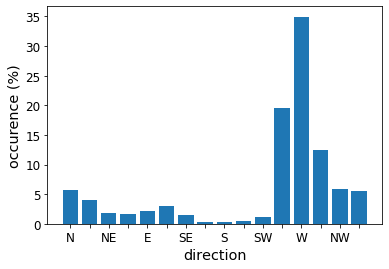

In [180]:
# Some probability distribution plots using the same data (just another way to look at them)
# Only the last one shown (nighttime, winter)

table = wa._info['table']
wd_freq = np.sum(table, axis=0)
direction = wa._info['dir']

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(np.arange(16), wd_freq, align='center')
ax.set_xticks(np.arange(16))
ax.set_xticklabels(['N','','NE','','E','','SE','','S','','SW','','W','','NW',''])
plt.tick_params(labelsize='large')
plt.xlabel('direction',fontsize='x-large')
plt.ylabel('occurence (%)',fontsize='x-large')
plt.show()

## 6. Thermal updrafts
Attempting to classify by thermal updrafts. The convective velocity for CBLs $w_*$ is given by
\begin{equation}
w_* = \left( \frac{g z_i \overline{(\theta'w')}_s}{\bar{\theta}} \right)^{1/3} 
\end{equation}

Greenhut and Khalsa (J. Clim. Appl. Meteorol., 1982) defined thermal updrafts and downdrafts as those parts of the data series that exceed a specific velocity threshold. Thermal updrafts are defined as that part of the data series in which the vertical velocity exceeds $0.56w_∗$, and thermal downdrafts are defined as that part of the data series in which the vertical velocity is less than $−0.40w_∗$.

The WIND toolkit dataset does not give individual components of the velocity. At this point, we will use the convective velocity as a direct measure of thermal updrafts.

### - Determine the heat flux and boundary layer height

In [206]:
z_i = 200
display(dfts)
aa=dfts.reset_index()
display(aa)
aaa=aa.loc[(aa['test']>0.1)]
display(aaa)

,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri,stability_zL,test,w*
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,-0.005493,76.10568,0.732422,0.000000,82520.523438,0.01,0.488319,23.511533,-0.042421,NU,-0.010987,0.542689
2011-01-01 01:00:00,-0.007324,76.53035,0.732422,0.000000,82549.820312,0.01,0.440878,23.079022,-0.047499,NU,-0.014649,0.539030
2011-01-01 02:00:00,-0.006714,74.86862,0.366211,0.000000,82559.890625,0.01,0.440988,21.174711,-0.017757,NU,-0.013428,0.523336
2011-01-01 03:00:00,-0.006714,76.02008,0.000000,0.000000,82550.734375,0.01,0.407729,16.734850,-0.018796,NU,-0.013428,0.484041
2011-01-01 04:00:00,-0.010987,79.47447,0.732422,0.000000,82562.640625,0.01,0.377586,21.750063,-0.031577,U,-0.021973,0.528484
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.000000,62.54158,0.000000,416.234300,83182.468750,0.01,0.457352,-0.000000,0.007969,N,0.000000,0.000000
2013-12-31 20:00:00,0.000610,62.24784,0.000000,397.488300,83128.453125,0.01,0.681897,-7.170460,0.017145,N,0.001221,NaN
2013-12-31 21:00:00,0.001831,65.35982,0.000000,306.459230,83132.117188,0.01,0.677749,-21.124570,0.029779,N,0.003662,NaN


,datetime,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri,stability_zL,test,w*
0,2011-01-01 00:00:00,-0.005493,76.10568,0.732422,0.000000,82520.523438,0.01,0.488319,23.511533,-0.042421,NU,-0.010987,0.542689
1,2011-01-01 01:00:00,-0.007324,76.53035,0.732422,0.000000,82549.820312,0.01,0.440878,23.079022,-0.047499,NU,-0.014649,0.539030
2,2011-01-01 02:00:00,-0.006714,74.86862,0.366211,0.000000,82559.890625,0.01,0.440988,21.174711,-0.017757,NU,-0.013428,0.523336
3,2011-01-01 03:00:00,-0.006714,76.02008,0.000000,0.000000,82550.734375,0.01,0.407729,16.734850,-0.018796,NU,-0.013428,0.484041
4,2011-01-01 04:00:00,-0.010987,79.47447,0.732422,0.000000,82562.640625,0.01,0.377586,21.750063,-0.031577,U,-0.021973,0.528484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2013-12-31 19:00:00,0.000000,62.54158,0.000000,416.234300,83182.468750,0.01,0.457352,-0.000000,0.007969,N,0.000000,0.000000
26300,2013-12-31 20:00:00,0.000610,62.24784,0.000000,397.488300,83128.453125,0.01,0.681897,-7.170460,0.017145,N,0.001221,NaN
26301,2013-12-31 21:00:00,0.001831,65.35982,0.000000,306.459230,83132.117188,0.01,0.677749,-21.124570,0.029779,N,0.003662,NaN
26302,2013-12-31 22:00:00,0.006714,66.29475,0.000000,136.051510,83117.468750,0.01,0.605609,-55.288358,0.057811,NS,0.013428,NaN


,datetime,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri,stability_zL,test,w*
48,2011-01-03 00:00:00,0.073855,66.517990,0.0,0.000000,83059.789062,0.01,0.257218,-46.677389,0.147229,VS,0.147710,NaN
49,2011-01-03 01:00:00,0.097659,69.003876,0.0,0.000000,83081.757812,0.01,0.209877,-33.549194,0.165847,VS,0.195318,NaN
50,2011-01-03 02:00:00,0.092166,71.051670,0.0,0.000000,83068.023438,0.01,0.206824,-30.282174,0.151905,VS,0.184332,NaN
52,2011-01-03 04:00:00,0.061037,71.640820,0.0,0.000000,83029.570312,0.01,0.265390,-42.331852,0.166450,VS,0.122074,NaN
60,2011-01-03 12:00:00,0.059206,76.526990,0.0,0.000000,83033.234375,0.01,0.295804,-56.896161,0.262584,VS,0.118412,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26245,2013-12-29 13:00:00,0.123905,87.225870,0.0,0.000000,83892.937500,0.01,0.164105,-20.550959,0.145682,VS,0.247810,NaN
26263,2013-12-30 07:00:00,0.073244,71.185950,0.0,0.000000,83186.132812,0.01,0.239265,-37.309180,0.363912,VS,0.146489,NaN
26264,2013-12-30 08:00:00,0.081179,68.743706,0.0,0.000000,83240.148438,0.01,0.237013,-40.244374,0.077694,VS,0.162358,NaN
26270,2013-12-30 14:00:00,0.051271,72.713400,0.0,0.000000,83641.164062,0.01,0.295187,-49.286360,0.166937,VS,0.102542,NaN


In [269]:
ts=dfts
cd=dfcd

,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri,stability_zL,test,w*
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,-0.005493,76.10568,0.732422,0.000000,82520.523438,0.01,0.488319,23.511533,-0.042421,NU,-0.010987,0.542689
2011-01-01 01:00:00,-0.007324,76.53035,0.732422,0.000000,82549.820312,0.01,0.440878,23.079022,-0.047499,NU,-0.014649,0.539030
2011-01-01 02:00:00,-0.006714,74.86862,0.366211,0.000000,82559.890625,0.01,0.440988,21.174711,-0.017757,NU,-0.013428,0.523336
2011-01-01 03:00:00,-0.006714,76.02008,0.000000,0.000000,82550.734375,0.01,0.407729,16.734850,-0.018796,NU,-0.013428,0.484041
2011-01-01 04:00:00,-0.010987,79.47447,0.732422,0.000000,82562.640625,0.01,0.377586,21.750063,-0.031577,U,-0.021973,0.528484
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.000000,62.54158,0.000000,416.234300,83182.468750,0.01,0.457352,-0.000000,0.007969,N,0.000000,0.000000
2013-12-31 20:00:00,0.000610,62.24784,0.000000,397.488300,83128.453125,0.01,0.681897,-7.170460,0.017145,N,0.001221,NaN
2013-12-31 21:00:00,0.001831,65.35982,0.000000,306.459230,83132.117188,0.01,0.677749,-21.124570,0.029779,N,0.003662,NaN


### - Estimate the convective velocity

In [209]:
U_at_z = cd['windspeed'].xs(40,level='height')

# Reverting the surface heat flux to Km/s from the saved W/m^2
Tw = ts['hfx']/(Cp*cd['density'].xs(2.0,level='height'))

z=200
z_i=200
T_at_z = cd['thetav'].xs(z,level='height')

ts['w*'] = (g*z_i*Tw/T_at_z)**(1/3)

In [290]:
# print(ts['w*'].describe())

In [291]:
# ax = ts['w*'].hist(bins=np.arange(0,3,0.03))
# plt.tick_params(labelsize='large')
# plt.xlabel(r'convective velocity (m/s)',fontsize='x-large')
# plt.ylabel(r'hours',fontsize='x-large')

count    3237.000000
mean        0.943007
std         0.377745
min         0.035048
25%         0.668635
50%         0.890785
75%         1.192785
max         1.943672
Name: w*, dtype: float64


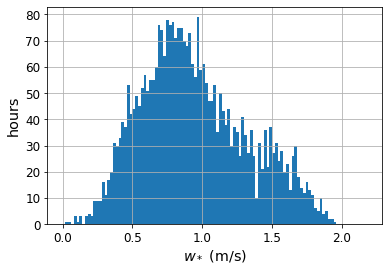

In [293]:
# Get the unstable scenarios only
temp = ts.loc[ts['stability_zL']=='U']
print(temp['w*'].describe())

ax = temp['w*'].hist(bins=np.arange(0,2.2,0.02))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_*$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

### - Estimate the mean vertical velocity in thermal updrafts
Using
\begin{equation}
\frac{\overline{w_T}}{w_*} = 0.85 \left( \frac{z}{z_i} \right)^{1/3} \left( 1.3 - \frac{z}{z_i} \right)
\end{equation}

from Shannon et al, BLM 104: 167--199, "MEASUREMENTS OF THERMAL UPDRAFT INTENSITY OVER COMPLEX TERRAIN USING AMERICAN WHITE PELICANS AND A SIMPLE BOUNDARY-LAYER FORECAST MODEL"

In [125]:
Tw = ts['hfx']/(Cp*cd['density'].xs(2.0,level='height'))
cd_ri = cd.reset_index()
z = cd.reset_index()['height'].values
#cd['wT'] = ts['w*']*0.85*(z/z_i)**(1/3)*(1.3-z/z_i)

